first we 

In [1]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())

__Python VERSION: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
__pyTorch VERSION: 1.2.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:12:52_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.1, V10.1.243
__CUDNN VERSION: 7401
__Number CUDA Devices: 1


In [2]:
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()

Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [3]:
print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

USE CUDA=True


In [4]:
import random 
import numpy as np

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)

In [5]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns

from torchvision.datasets import FashionMNIST

batch_size = 32

In [51]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split

transform = transforms.Compose(
    [transforms.ToTensor(),])
#      transforms.Normalize(0.5, 0.5)])

training_data = FashionMNIST('./datasets/',download=True,train=True,transform=transform)
train_set, val_set = random_split(training_data,[int(training_data.__len__()*0.8),int(training_data.__len__()*0.2)])
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=6)
val_loader = DataLoader(val_set, batch_size=batch_size,shuffle=True, num_workers=6)

test_set = FashionMNIST('./datasets/',download=True,train=False,transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True, num_workers=6)

In [53]:
print('train size=',train_set.__len__(),' validation size=', val_set.__len__())

train size= 48000  validation size= 12000


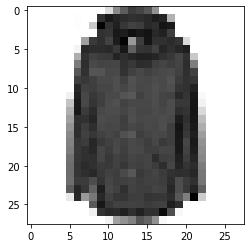

In [55]:
plt.imshow(iter(train_loader).next()[0].numpy()[0][0],cmap='binary')

In [70]:
class_names = {k:v for k,v in enumerate('T-shirt/top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Ankle_boot'.split(' '))}

In [71]:
class_names

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle_boot'}

In [74]:
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(nrow*ncol):
        ax[i//ncol,i%ncol].imshow(X[skip+i],cmap='binary')
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.55, -0.35, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='green' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, -0.15, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, -0.15, class_names[y[skip+i]], color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    plt.show()

X_train = iter(train_loader).next()[0].numpy()[:,0,:,:]
y_train = iter(train_loader).next()[1].numpy()

In [57]:
X_train.shape

(32, 28, 28)

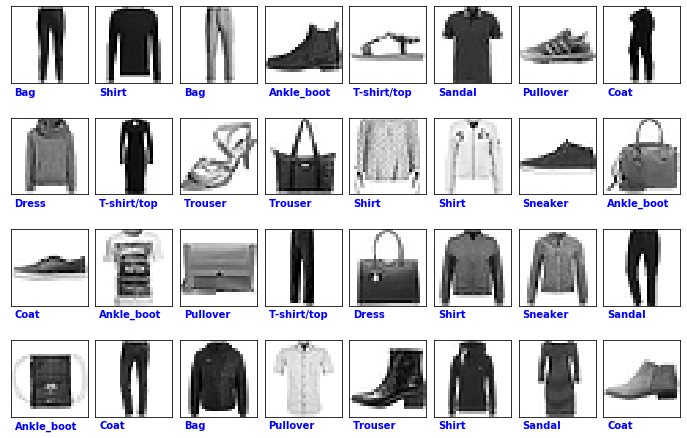

In [75]:
plot_multiple_imgs(X_train,y_train,batch_size//8,8,(12,8))

our initial network will be a fully connected network which means every neuron in a specific layer is connected to every neuron in the succiding layer

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# every network class has to include at least 2 methods:
#     an init method - will define the computational graph components
#     and a forward method which will define the graph structure

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784,20)
        self.fc2 = nn.Linear(20,10)
        
    def forward(self,x):
        x = x.view(batch_size,-1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x
    
m = MLP()

print(m)

MLP(
  (fc1): Linear(in_features=784, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)


In [90]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(m.parameters(),lr = 0.001)

In [93]:
if use_cuda:
    m.cuda()
    criterion.cuda()
        
def get_val_loss(model,val_loader,criterion):
    val_preds = []
    val_true = []
    with torch.no_grad():
        for (inp,labels) in val_loader:
            if use_cuda:
                inp = inp.cuda()
                labels = labels.cuda()
                val_preds.append(model(inp))
                val_true.append(labels)
        val_preds = torch.cat(val_preds)
        val_true = torch.cat(val_true)
    return criterion(val_preds, val_true).item()
  

In [95]:
      
for epoch in range(4):
    running_loss = 0.0
    for i,(inp,labels) in enumerate(train_loader, 0):
        if use_cuda:
            inp = inp.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        out = m(inp)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % (batch_size*10) == (batch_size*10-1):
            print('epoch {}, iteration {}, loss={:3f}, validation_loss={:3f}'.format(epoch,i,running_loss/(batch_size*10),get_val_loss(m,val_loader,criterion)))
            running_loss = 0.0

C:\Users\nathaniels\Anaconda3\envs\dsn\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0, iteration 319, loss=1.658123, validation_loss=1.666770
epoch 0, iteration 639, loss=1.667349, validation_loss=1.665783
epoch 0, iteration 959, loss=1.660836, validation_loss=1.666651
epoch 0, iteration 1279, loss=1.658456, validation_loss=1.666039
epoch 1, iteration 319, loss=1.664688, validation_loss=1.661236
epoch 1, iteration 639, loss=1.650091, validation_loss=1.671151
epoch 1, iteration 959, loss=1.657930, validation_loss=1.663791
epoch 1, iteration 1279, loss=1.660856, validation_loss=1.664061
epoch 2, iteration 319, loss=1.654657, validation_loss=1.661639
epoch 2, iteration 639, loss=1.656581, validation_loss=1.666019
epoch 2, iteration 959, loss=1.659820, validation_loss=1.665024
epoch 2, iteration 1279, loss=1.652408, validation_loss=1.664699
epoch 3, iteration 319, loss=1.649080, validation_loss=1.669327
epoch 3, iteration 639, loss=1.652795, validation_loss=1.662004
epoch 3, iteration 959, loss=1.655033, validation_loss=1.664623
epoch 3, iteration 1279, loss=1.65194

In [37]:
class CONV(nn.Module):
    def __init__(self):
        super(CONV, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1,32,3)  #input dims are 1x28x28  output dims are 32x26x26
        self.conv2 = nn.Conv2d(32,32,3)  #input dims are 32x26x26  output dims are 32x24x24
        self.conv3 = nn.Conv2d(32,16,3)  #input dims are 32x12x12  output dims are 16x10x10
        self.conv4 = nn.Conv2d(16,16,3)  #input dims are 16x10x10  output dims are 16x8x8
        self.flat_dim = (4*4)*16
        self.fc1 = nn.Linear(self.flat_dim,20) 
        self.fc2 = nn.Linear(20,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1,self.flat_dim)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

In [38]:
c = CONV()
print(c)

CONV(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)


In [39]:
optimizer = optim.Adam(c.parameters(),lr = 0.001)

In [47]:
if use_cuda:
    c.cuda()
    criterion.cuda()
        
for epoch in range(4):
    running_loss = 0.0
    for i,(inp,labels) in enumerate(train_loader, 0):
        if use_cuda:
            inp = inp.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        out = c(inp)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % (batch_size*10) == (batch_size*10-1):
            print('epoch {}, iteration {}, loss={:3f}'.format(epoch,i,running_loss/(batch_size*10)))
            running_loss = 0.0

C:\Users\nathaniels\Anaconda3\envs\dsn\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0, iteration 319, loss=1.654447
epoch 0, iteration 639, loss=1.652294
epoch 0, iteration 959, loss=1.651309
epoch 0, iteration 1279, loss=1.647434
epoch 0, iteration 1599, loss=1.651768
epoch 1, iteration 319, loss=1.647489
epoch 1, iteration 639, loss=1.650430
epoch 1, iteration 959, loss=1.652891
epoch 1, iteration 1279, loss=1.644650
epoch 1, iteration 1599, loss=1.647773
epoch 2, iteration 319, loss=1.644721
epoch 2, iteration 639, loss=1.639968
epoch 2, iteration 959, loss=1.651622
epoch 2, iteration 1279, loss=1.653072
epoch 2, iteration 1599, loss=1.645238
epoch 3, iteration 319, loss=1.643371
epoch 3, iteration 639, loss=1.649491
epoch 3, iteration 959, loss=1.642990
epoch 3, iteration 1279, loss=1.650650
epoch 3, iteration 1599, loss=1.644881
